#연봉 예측  
2017년의 데이터를 기반으로 KBO투수들의 2018년 연봉을 통계가 아닌 딥러닝으로 예측해보자.   
'이것이 데이터분석 이다 with 파이썬'을 일부 참고함.
    
   
------------------------------------

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

picher_file_path = 'C:/Users/USer/Downloads/picher_stats_2017.csv'
picher = pd.read_csv(picher_file_path, encoding='euc-kr')

picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

2017년 투수들의 데이터 및 연봉 그리고 2018 연봉을 정리해놓은 picher_stats_2017.csv 파일을 사용했다.   
csv파일을 열었을 때 글씨가 깨져서 한글로 다시 encoding 해주었다.

In [2]:
picher.head() 

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


처음 5줄의 데이터 출력

In [3]:
print(picher.shape)

(152, 22)


총 152명의 선수의 데이터가 있음을 알 수 있다.

In [4]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

2018 연봉의 평균, 표준편차, 4분위수 등을 알 수 있다.

<AxesSubplot:>

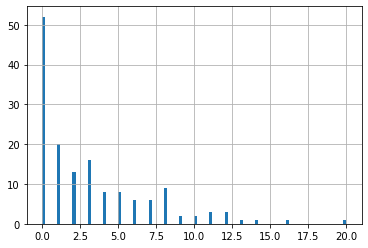

In [5]:
picher['승'].hist(bins=100)

2017년 투수들의 승수를 x축을 100등분한 그래프로 볼 수 있다.   
데이터셋에 승이 없는 중간계투, 마무리투수 등의 선수들도 많으므로 승이 0인 선수들이 비교적 많은 것으로 나타난다.

<AxesSubplot:>

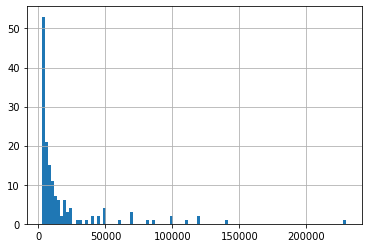

In [6]:
picher['연봉(2018)'].hist(bins=100)

2018년 투수들의 연봉을 x축을 100등분한 그래프로써 나타낸다.   
상대적으로 연봉을 적게 받는 선수들이 더 많은 것을 알 수 있다. 

In [7]:
print(picher.loc[:, '연봉(2018)'].idxmax())
print(picher.loc[:, '승'].idxmax())

2
2


위 두 그래프에서 가장 오른쪽에 있는 극값이 오류가 아닌 지 알아보기 위해 maximum값을 찾아보았다.   
모두 2번 인덱스 값인 걸로 나타났다.

In [8]:
df = pd.DataFrame(picher)
df.query('2')

선수명            양현종
팀명             KIA
승               20
패                6
세                0
홀드               0
블론               0
경기              31
선발              31
이닝           193.1
삼진/9          7.36
볼넷/9          2.09
홈런/9          0.79
BABIP        0.332
LOB%          72.1
ERA           3.44
RA9-WAR       6.54
FIP           3.94
kFIP          3.82
WAR           5.64
연봉(2018)    230000
연봉(2017)    150000
Name: 2, dtype: object

`pandas`의 `DataFrame()`함수를 이용하여 인덱스가 2인 선수를 찾아 그 선수의 승과 연봉을 두 그래프와 비교했다.
2017년 기아 타이거즈의 양현종 선수의 승과 2018년 연봉이 각각 20, 230000 만원인 것으로 나타났다.

In [9]:
pd.options.mode.chained_assignment = None

데이터프레임을 복사해 다른 데이터프레임을 만들 때 종종 경고가 뜨며 코드가 멈추는 상황이 발생하는데, 그 경고를 끄고 무시하는 코드이다. 

In [10]:
def standard_scaling(df, scale_columns): #표준화
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

스케일링, 즉 표준화를 시키는 코드이다.   
표준정규분포로써 나타낼 수 있으며, 데이터마다 데이터의 크기가 모두 다르기 때문에 표준화를 시켜 값의 차이가 많이 나지 않도록 만들어준다.   
모든 데이터에 평균을 뺀 후에 표준편차로 나누어 계산한다.

In [11]:
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']

picher_df = standard_scaling(picher, scale_columns)

'연봉(2018)'을 제외한 나머지 데이터들을 스케일링하여 나타낸다.

In [12]:
picher_df = picher.rename(columns={'연봉(2018)': 'y'}) #2018 연봉을 y값으로 설정하기 위해 이름 변경
picher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


'연봉(2018)' 데이터는 y값으로 나타낸다.    
스케일링이 된 상위 5개 데이터들을 출력한다. 

<AxesSubplot:>

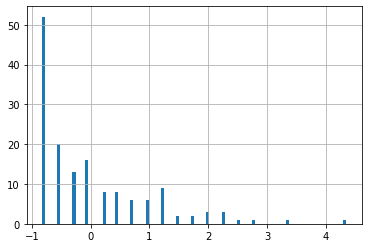

In [13]:
picher_df['승'].hist(bins=100)

스케일링 전의 그래프와 다르게 그래프의 정의역의 크기가 작아진 것을 볼 수 있다. 

In [14]:
team_encoding = pd.get_dummies(picher_df['팀명'])
picher_df = picher_df.drop('팀명', axis=1)
picher_df = picher_df.join(team_encoding)

In [15]:
team_encoding.head()

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


연봉에 영향을 주는 팀명을 컴퓨터가 그대로 이해하지 못하므로 팀명을 one hot encoding으로 변환한다.   
LG의 경우 [001000000]로 나타낸다.

In [16]:
picher_df

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,-0.309907,0.588357,-0.306452,-0.585705,0.680497,0.214300,-0.112010,0.104300,-0.968896,...,-0.335587,0,0,0,0,0,0,0,0,1
148,정용운,-0.051084,-0.369825,-0.306452,-0.585705,-0.543592,-0.198678,0.503369,0.042667,-0.777918,...,-0.535215,1,0,0,0,0,0,0,0,0
149,노경은,-0.827554,-0.369825,-0.306452,-0.585705,-0.543592,-1.024633,-0.419699,-0.850019,-0.756699,...,-0.020173,0,0,0,0,0,0,1,0,0
150,김승현,-0.827554,-0.050431,-0.306452,-0.364245,-0.543592,0.627278,-0.624825,-0.273451,0.205264,...,-0.543201,0,0,0,0,0,0,0,1,0


스케일링과 팀명 변환까지 완료된 데이터셋이다.

In [17]:
from sklearn.model_selection import train_test_split


x = picher_df[picher_df.columns.difference(['선수명', 'y'])] #선수명 ,y를 제외한 나머지 컬럼 인덱스
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=19)

sklearn을 이용하여 train셋과 test셋을 분리시켜준다.   
X에 '선수명'과 'y'를 제외한 나머지 컬럼들을 인덱스해주고 y에는 'y'를 인덱스해준다.   
test_size, 즉 test셋으로 분리될 데이터들은 전체 데이터의 30퍼센트인 0.3으로 설정해준다.

In [18]:
X_train.shape

(106, 28)

In [19]:
X_test.shape

(46, 28)

In [20]:
X_train.shape

(106, 28)

In [21]:
y_train.shape

(106,)

In [22]:
import tensorflow as tf

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\appdata\

딥러닝을 사용할 것이므로 딥러닝에 자주 사용되는 모듈인 텐서플로우를 import해준다. 

In [23]:
X = tf.placeholder(tf.float32, shape=[None,28])
Y = tf.placeholder(tf.float32, shape=[None])

W = tf.Variable(tf.random_normal([28,1]))
b = tf.Variable(tf.random_normal([1]))

Instructions for updating:
Colocations handled automatically by placer.


X값과 Y값은 코드를 먼저 구축한 후 나중에 대입하기 위해 `placeholder`를 사용하여 임시로 설정해준다.   
W값과 b값은 변수이므로 `Variable`을 사용하여 만들어준다.

In [24]:
hypothesis = tf.matmul(X,W)+b

$\hat{y} = XW + b$ 인 linear regression 함수를 사용하여 hypothesis를 설정해준다.    
X와 W는 메트릭스이므로 `matmul()`함수를 사용하여 곱해준다.

In [25]:
cost = tf.reduce_mean(tf.square(hypothesis - Y))

$\frac{1}{n}\Sigma(\hat{y} - y)^2$ 인 cost함수를 설정한다.    
이를 사용하면서 차원이 줄어든다.

In [26]:
train = tf.train.GradientDescentOptimizer(learning_rate=.0003).minimize(cost)

`tf.train.GradientDescentOptimizer()`를 사용하여 cost값을 minimize한다.   
learning_rate는 바꿔가며 적절한 값을 찾는다.

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) #세션을 열어준다

    for step in range(10001): #train셋
        cost_val, _ = sess.run([cost, train], feed_dict={X: X_train, Y: y_train}) #X값에 X_train 대입, Y값에 y_train 대입
        if step % 200 == 0: #200번에 한번씩 결과값 출력
            print(step, cost_val)

    h,W,b = sess.run([hypothesis,W,b],feed_dict={X: X_test, Y: y_test}) #test셋, X값에 X_test 대입, Y값에 y_test 대입
    print("\nHypothesis: ", h)

0 1012787100.0
200 931598100.0
400 871063360.0
600 825393540.0
800 790697200.0
1000 764229400.0
1200 743987300.0
1400 728482400.0
1600 716593300.0
1800 707469760.0
2000 700463800.0
2200 695081000.0
2400 690942700.0
2600 687759500.0
2800 685308900.0
3000 683421400.0
3200 681966100.0
3400 680843000.0
3600 679975500.0
3800 679304100.0
4000 678784260.0
4200 678380740.0
4400 678067400.0
4600 677823170.0
4800 677632300.0
5000 677483000.0
5200 677365600.0
5400 677273000.0
5600 677200100.0
5800 677141700.0
6000 677095200.0
6200 677057600.0
6400 677027140.0
6600 677002700.0
6800 676982460.0
7000 676965440.0
7200 676951700.0
7400 676939800.0
7600 676930050.0
7800 676921340.0
8000 676914200.0
8200 676907700.0
8400 676902200.0
8600 676897100.0
8800 676892740.0
9000 676888500.0
9200 676884860.0
9400 676881700.0
9600 676878460.0
9800 676875800.0
10000 676873100.0

Hypothesis:  [[18766.441]
 [17940.992]
 [18453.443]
 [18159.17 ]
 [18417.113]
 [18305.07 ]
 [17700.752]
 [17875.342]
 [18007.617]
 [17957

In [28]:
pd.DataFrame([X_test.columns,W]).T

,0,1
0,BABIP,[-1.8991873]
1,ERA,[241.58405]
2,FIP,[-18.205677]
3,KIA,[1919.076]
4,KT,[1779.2285]
5,LG,[1551.3867]
6,LOB%,[181.55801]
7,NC,[1749.9974]
8,RA9-WAR,[-105.62932]
9,SK,[2079.7664]


결과값이 통계로 돌린 예측값과 크게 차이가 난다.   
   
예를 들어, 투수에게 높을 수록 유리한 승과 홀드가 높아도 연봉상승에 영향을 많이 미치지 않는 것으로 해석이 된다.   
승 수가 별로 없는 계투나 마무리투수의 경우에도 성적이 좋으면 높은 연봉을 받을 수 있기 때문에 이가 영향을 미친 것으로 추측된다.   
반대로 홀드는 오직 계투들에게만, 세이브는 마무리투수들에게만 적용되는 데이터이다. 선발투수들은 홀드나 세이브 기록을 올리는 경우가 거의 없기 때문에 성적이 좋은 선발투수들도 홀드나 세이브가 없음에도 높은 연봉을 받는 것이 당연하다.   
   
또한 딥러닝을 돌리기에는 데이터가 많이 부족한 것일 수도 있다. 오직 2017년의 데이터들만 가지고 하기에는 많은 데이터를 요구하는 딥러닝에서는 정확한 결과가 나오지 않을 수도 있다. 